# CdcGAN (conditional deep convolutional Generative Adversarial Network)
Additional information that is correlated with the input images, such as class labels, can be used to improve the GAN. This improvement may come in the form of more stable training, faster training, and/or generated images that have better quality. Class labels can also be used for the deliberate or targeted generation of images of a given type.

There are many ways to encode and incorporate the class labels into the discriminator and generator models. A best practice involves using an embedding layer followed by a fully connected layer with a linear activation that scales the embedding to the size of the image before concatenating it in the model as an additional channel or feature map. The class labels are one hot encoded and concatenated with the input to both the generator and discriminator models.

In [22]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#### Training normal GAN

GAN model takes as input a point in the latent space, uses the generator model to generate an image which is fed as input to the discriminator model, then is output or classified as real or fake.
(point --> generator --> image --> discriminator --> real/fake)

In [ ]:
from tensorflow.keras.utils import plot_model
from os import listdir
from os.path import join
import numpy as np
from PIL import Image

path_arts = []
distinct_labels= []
training_dir = 'drive/My Drive/kaggle'
artists = sorted(listdir(training_dir))

for artist in artists:
    for file in listdir(join(training_dir,artist)):
        if '.jpg' in file:
            path_arts.append(join(training_dir,artist,file))
            distinct_labels.append(artist)        

In [24]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def load_images(size):
    
    normalize = lambda x: (x.astype('float32') - 127.5) / 127.5 # normalize to between -1: and 1

    img_gen = ImageDataGenerator(preprocessing_function=normalize, zoom_range=0.1, rotation_range=0.05)#, validation_split=0.2)    

    train_generator = img_gen.flow_from_directory( batch_size=1,
                                                   directory=training_dir,
                                                   shuffle=True,
                                                   target_size=size, 
                                                   subset="training",
                                                   class_mode='categorical')
    
    #train_dataset = tf.data.Dataset.from_generator(lambda: train_generator,
    #                                                   output_types=(tf.float32, tf.float32),
    #                                                   output_shapes=([None, size[0],size[1], 3], [None, 51]))
    #train_dataset = train_dataset.repeat()
    #valid_dataset = img_gen.flow_from_directory(batch_size=32, directory=training_dir, shuffle=True, target_size=(256, 256),  subset="validation", class_mode='categorical')
    
    return train_generator  #train_dataset

In [25]:
indices = load_images((64,64)).class_indices #cambiabile

Found 3219 images belonging to 18 classes.


In [27]:
from tensorflow.keras.datasets.fashion_mnist import load_data
from numpy import ones, expand_dims
from numpy.random import randint

# loading the dataset
def load_real_samples(indices):

    print("Gathering data...")

    # Images
    images,i = [],0
    for img in path_arts:
      if i%200==0: print(str(i) + " images")
      images.append(np.array((Image.open(img)).resize((64,64))))
      i += 1
    
    for i in range(len(images)):
      images[i] = ((images[i] - images[i].min())/(255 - images[i].min()))
      images[i] = images[i]*2-1  #uncomment this if activation is tanh for generator last layer
        
    print("Done!")
    images = np.array(images)

    # Labels
    labels = [indices[el] for el in distinct_labels] 
    labels = np.array(labels, dtype="uint8")

    return [images, labels] 

# selecting a batch of real samples
def generate_real_samples(dataset, n_samples):
    
    # split into images and labels
    images, labels = dataset
    # choose random instances
    indexes = randint(0, images.shape[0], n_samples) #n_files+1
    
    # select images and labels
    X, my_labels = images[indexes], labels[indexes]
          # my_labels = [labels[i] for i in indexes] 
          # X = [images[i] for i in indexes] #images[i]
   
    # generate class labels
    y = ones((n_samples, 1))
    
    return [X, my_labels], y

Generate an array of randomly selected integer class labels to go along with the randomly selected points in the latent space.

In [28]:
from numpy.random import randn
from numpy import zeros

# generate points in latent space as input for the generator
def generate_latent_points(n_samples, latent_dim, n_classes):

    # generate points in the latent space #Return a sample (or samples) from the “standard normal” distribution.
    x_input = randn(latent_dim * n_samples)
    # reshape into a batch of inputs for the network  # reorganize in rows x cols
    z_input = x_input.reshape(n_samples,latent_dim)
  
    # generate n_samples random labels from 0 to n_classes
    labels = randint(0, n_classes, n_samples)
 
    # returns n_samples random numbers vectors of length latent_dim and n_samples random labels 
    return [z_input, labels]

# Use the generator to generate(predict) n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n_samples):
   
    # generate points in latent space
    z_input, labels_input = generate_latent_points(n_samples, latent_dim, n_classes=len(artists))
    # predict outputs
    images = generator.predict([z_input, labels_input])
    
    # create class labels
    y = zeros((n_samples, 1))
    
    return [images, labels_input], y

### cGAN architecture overview

![cGAN_architecture-2.png](attachment:cGAN_architecture-2.png)

## Discriminator

The class label is then passed through an Embedding layer with the size of 50. This means that each of the 10 classes for the Fashion MNIST dataset (0 through 9) will map to a different 50-element vector representation that will be learned by the discriminator model.

In [29]:
from tensorflow.keras.layers import Input, LeakyReLU, Dropout, Embedding, Concatenate
from tensorflow.keras.layers import Dense, Reshape, Flatten, Conv2D, Conv2DTranspose
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model

def define_discriminator(input_shape, n_classes):
    
    # label input
    class_label = Input(shape=(1,))
    # embedding for categorical input
    x = Embedding(n_classes, 5*n_classes)(class_label)
    
    # scale up to image dimensions with linear activation
    n_nodes = input_shape[0] * input_shape[1]
    x = Dense(n_nodes)(x)
    # reshape to additional channel
    x = Reshape((input_shape[0], input_shape[1], 1))(x)
    
    # image input
    input_image = Input(shape=input_shape)
    # concat label as a channel
    merge = Concatenate()([input_image, x])
    
    # downsample
    y = Conv2D(128, (3,3), strides=(2,2), padding='same')(merge)
    y = LeakyReLU(alpha=0.2)(y)
    # downsample
    y = Conv2D(128, (3,3), strides=(2,2), padding='same')(y)
    y = LeakyReLU(alpha=0.2)(y)
    
    # flatten feature maps
    y = Flatten()(y)
    # dropout
    y = Dropout(0.4)(y)
    
    # output
    output_layer = Dense(1, activation='sigmoid')(y)
    # define model
    model = Model([input_image, class_label], output_layer)
    model._name = "discriminator"
    
    return model

In [30]:
# create the discriminator
discriminator = define_discriminator(input_shape=(64,64,3), n_classes=len(artists))

# compile discriminator
discriminator.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0002, beta_1=0.5), metrics=['accuracy'])
discriminator.summary()

Model: "discriminator"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 1, 90)        1620        input_5[0][0]                    
__________________________________________________________________________________________________
dense_4 (Dense)                 (None, 1, 4096)      372736      embedding_2[0][0]                
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, 64, 64, 3)]  0                                            
______________________________________________________________________________________

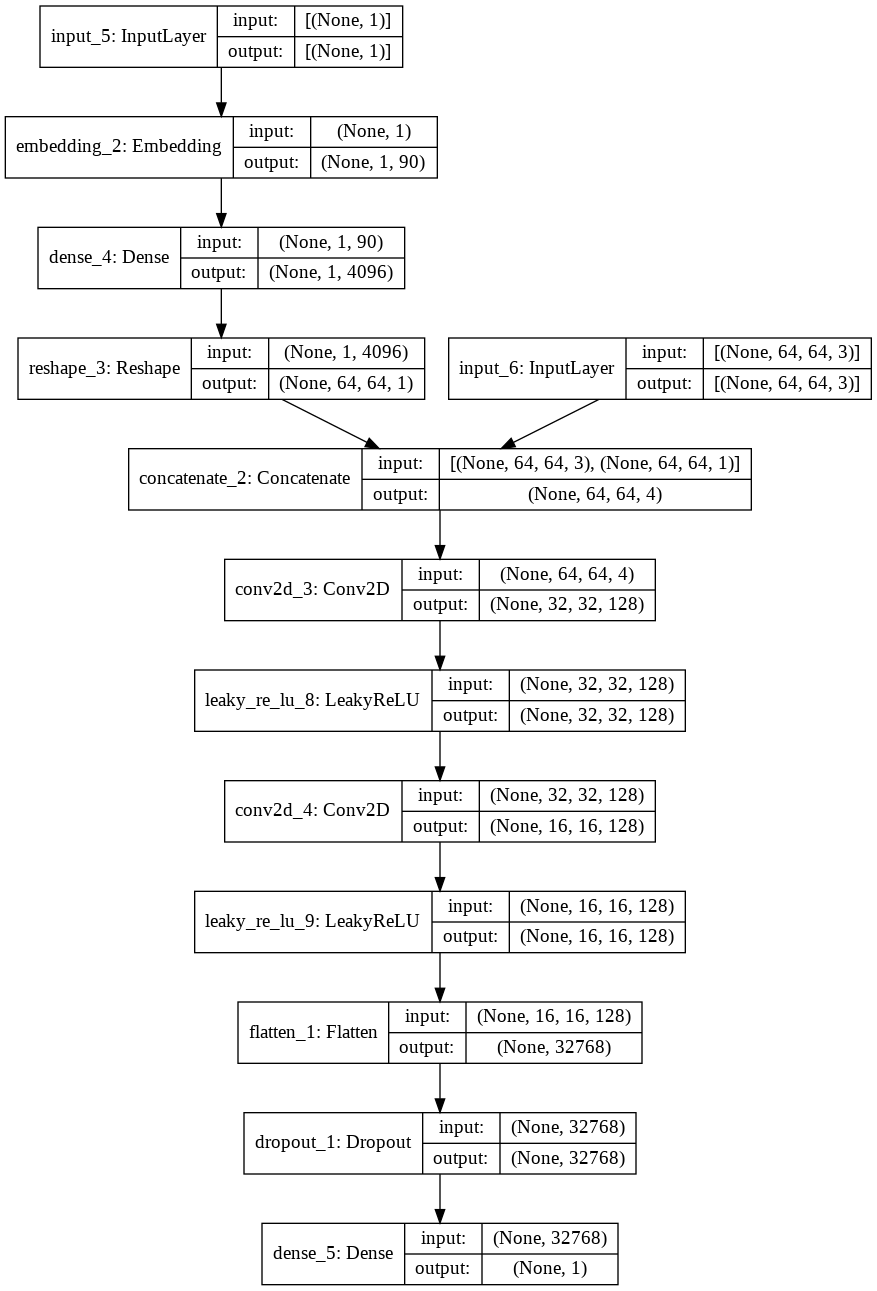

In [31]:
plot_model(discriminator, to_file='discriminator_plot.png', show_shapes=True, show_layer_names=True)

## Generator

Next, the generator model must be updated to take the class label. This has the effect of making the point in the latent space conditional on the provided class label.
In this case, the activations of the fully connected layer are resized into a single 7×7 feature map. The new 7×7 feature map is added as one more channel to the existing 128, resulting in 129 feature maps that are then upsampled as in the prior model

In [32]:
def define_generator(latent_dim, n_classes, input_shape):
    
    # label input
    class_label = Input(shape=(1,))
    # embedding for categorical input
    x = Embedding(n_classes, 5*n_classes)(class_label)
    
    # linear multiplication
    n_nodes = 8 * 8
    x = Dense(n_nodes)(x)
    # reshape to additional channel
    x = Reshape((8, 8, 1))(x)
    
    # image generator input
    latent_input = Input(shape=(latent_dim,))
    # foundation for 7x7 image
    n_nodes = 128 * 8 * 8
    gen = Dense(n_nodes)(latent_input)
    gen = LeakyReLU(alpha=0.2)(gen)
    gen = Reshape((8, 8, 128))(gen)
    
    # merge image gen and label input
    merge = Concatenate()([gen, x])
    
    # upsample to 14x14
    gen = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(merge)
    gen = LeakyReLU(alpha=0.2)(gen)
    # upsample to 28x28
    gen = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(gen)
    gen = LeakyReLU(alpha=0.2)(gen)
    
    # new
    
    # upsample to 64x64
    gen = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(gen)
    gen = LeakyReLU(alpha=0.2)(gen)
    # upsample to 128x128
     # gen = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(gen)
     # gen = LeakyReLU(alpha=0.2)(gen)
    # upsample to 256x256
     # gen = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(gen)
     # gen = LeakyReLU(alpha=0.2)(gen)
    
    # output
    output_layer = Conv2D(3, (7,7), activation='tanh', padding='same')(gen)   #[-1,1]

    # define model
    model = Model([latent_input, class_label], output_layer)
    
    model._name = "generator"
    
    return model

In [33]:
# create the generator
generator = define_generator(latent_dim=100,n_classes=len(artists),input_shape=(64,64,3))
generator.summary()

Model: "generator"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
input_7 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
dense_7 (Dense)                 (None, 8192)         827392      input_8[0][0]                    
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 1, 90)        1620        input_7[0][0]                    
__________________________________________________________________________________________

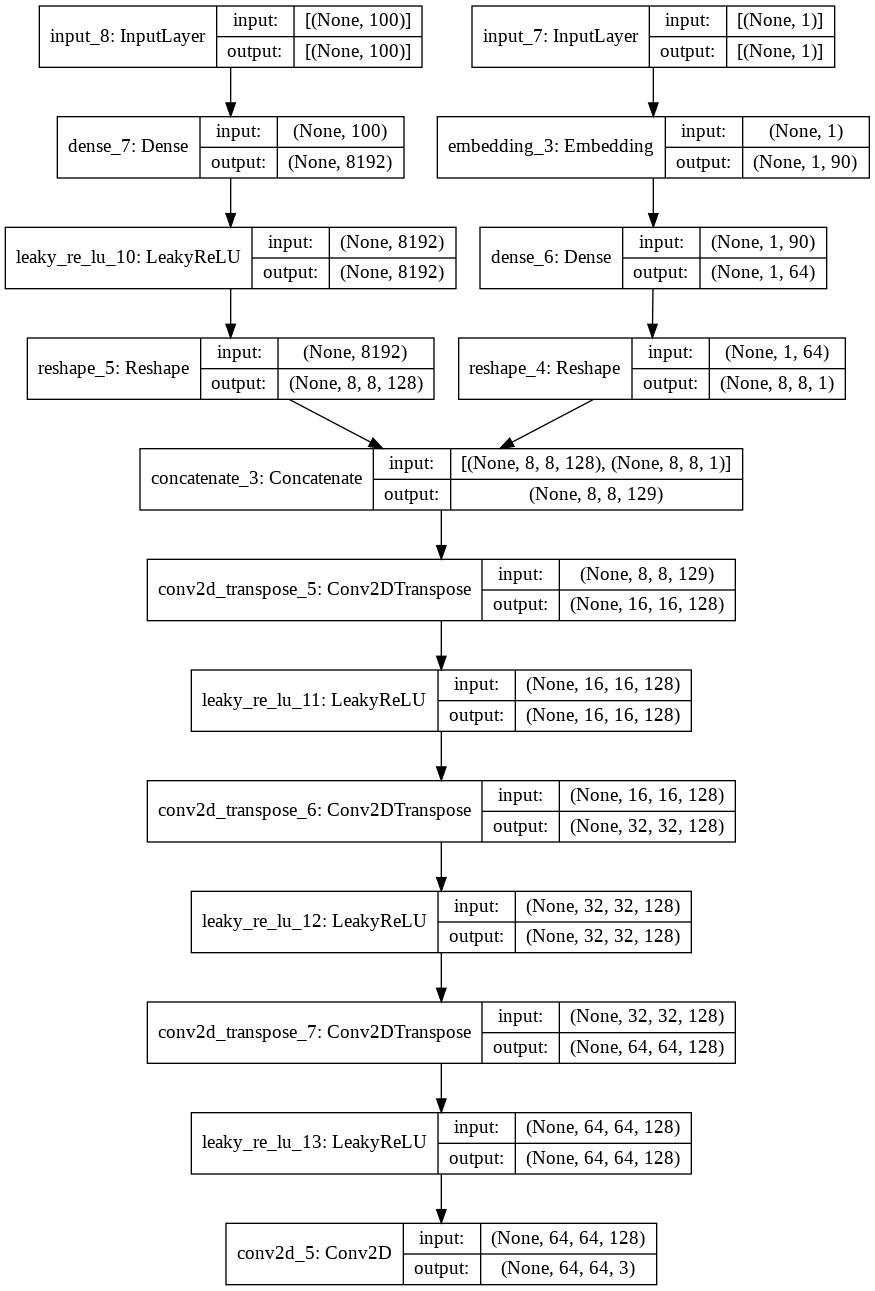

In [34]:
plot_model(generator, to_file='generator_plot.png', show_shapes=True, show_layer_names=True)

# cGAN

cGAN model will take as input (a point in latent space, class label) and generate a prediction of whether input was real or fake, as a normal GAN. It is important that we explicitly connect the image generated output from the generator as well as the class label input, both as input to the discriminator model. This allows the same class label input to flow down into the generator and down into the discriminator.

In [35]:
# define the combined generator and discriminator model, for updating the generator
def define_gan(generator, discriminator):
    
    # make weights in the discriminator not trainable
    discriminator.trainable = False
    
    # get noise and label inputs from generator model
    gen_noise, gen_label = generator.input
    # get image output from the generator model
    gen_image = generator.output
    
    # connect image output and label input from generator as inputs to discriminator
    cgan_output = discriminator([gen_image, gen_label])
    
    # define gan model as taking (input noise,input label), and outputting a classification
    cGAN = Model([gen_noise, gen_label], cgan_output)
    cGAN._name = "GAN"
   
    return cGAN

In [36]:
# create the gan
cGAN = define_gan(generator,discriminator)

# compile model
cGAN.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0002, beta_1=0.5))
cGAN.summary()

Model: "GAN"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
input_7 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
dense_7 (Dense)                 (None, 8192)         827392      input_8[0][0]                    
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 1, 90)        1620        input_7[0][0]                    
________________________________________________________________________________________________

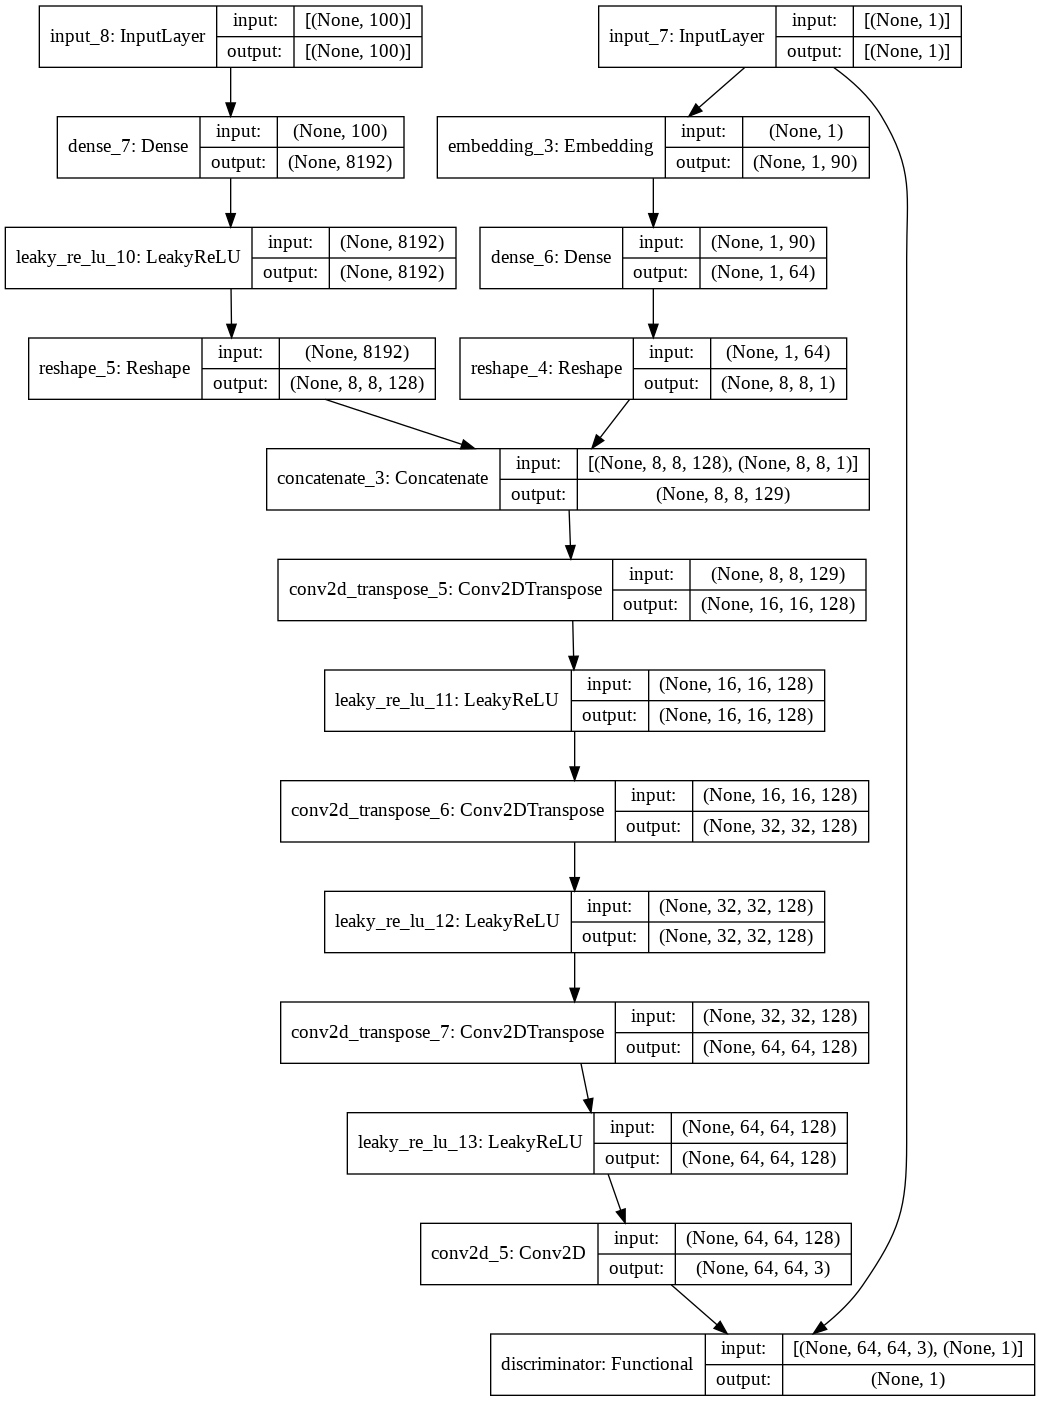

In [37]:
plot_model(cGAN, to_file='cGAN_plot.png', show_shapes=True, show_layer_names=True)

In [38]:
# load image data
dataset = load_real_samples(indices)
print("all images: " + str(dataset[0].shape))
print("all labels: " + str(dataset[1].shape))

Gathering data...
0 images
200 images
400 images
600 images
800 images
1000 images
1200 images
1400 images
1600 images
1800 images
2000 images
2200 images
2400 images
2600 images
2800 images
3000 images
3200 images
Done!
all images: (3219, 64, 64, 3)
all labels: (3219,)


## Training
Since we are training two models at once, the discriminator and the generator, we can’t rely on Keras’ .fit function. Instead, we have to manually loop through each epoch and fit the models on batches.
Use also the class labels in the calls to updating the discriminator and generator models.

In [43]:
# train the generator and discriminator

def train(generator, discriminator, cGAN, dataset, latent_dim, n_epochs=25, n_batch=128):
    
    bat_per_epo = int(dataset[0].shape[0] / n_batch) 
    half_batch = int(n_batch / 2)
    
    # manually enumerate epochs
    for i in range(n_epochs):
        
        # enumerate batches over the training set
        for j in range(bat_per_epo):

            # get randomly selected 'real' samples and update discriminator model weights
            [X_real, labels_real], y_real = generate_real_samples(dataset, half_batch)
            d_loss1, _ = discriminator.train_on_batch([X_real, labels_real], y_real)
            
            # generate 'fake' examples and update discriminator model weights
            [X_fake, labels_fake], y_fake = generate_fake_samples(generator, latent_dim, half_batch)
            d_loss2, _ = discriminator.train_on_batch([X_fake, labels_fake], y_fake)
            
            # prepare points in latent space as input for the generator
            [z_input, labels_input] = generate_latent_points(n_batch, latent_dim, n_classes=len(artists))
            # create inverted labels for the fake samples
            y_gan = ones((n_batch, 1)) #n_batch
            # update the generator via the discriminator's error
            g_loss = cGAN.train_on_batch([z_input, labels_input], y_gan)

            # summarize loss on this batch
            if j+1 == bat_per_epo:
                print('>Epoch %d: [%d/%d]\t discriminator_loss1=%.3f  -  discriminator_loss2=%.3f  -  generator_loss=%.3f' 
                       %(i+1, j+1, bat_per_epo,  d_loss1, d_loss2, g_loss))
   
    # save the generator model at the end
    generator.save('cGAN_generator.h5')


In [44]:
train(generator, discriminator, cGAN, dataset, latent_dim=100)

>Epoch: 1, 25/25	 discriminator_loss1=1.936  -  discriminator_loss2=1.117  -  generator_loss=4.585
>Epoch: 2, 25/25	 discriminator_loss1=0.582  -  discriminator_loss2=0.310  -  generator_loss=2.838
>Epoch: 3, 25/25	 discriminator_loss1=0.481  -  discriminator_loss2=0.158  -  generator_loss=2.518
>Epoch: 4, 25/25	 discriminator_loss1=0.300  -  discriminator_loss2=0.387  -  generator_loss=2.104
>Epoch: 5, 25/25	 discriminator_loss1=0.292  -  discriminator_loss2=0.357  -  generator_loss=1.976
>Epoch: 6, 25/25	 discriminator_loss1=0.381  -  discriminator_loss2=0.583  -  generator_loss=2.976
>Epoch: 7, 25/25	 discriminator_loss1=0.624  -  discriminator_loss2=0.401  -  generator_loss=1.833
>Epoch: 8, 25/25	 discriminator_loss1=0.408  -  discriminator_loss2=0.464  -  generator_loss=1.796
>Epoch: 9, 25/25	 discriminator_loss1=0.490  -  discriminator_loss2=0.631  -  generator_loss=1.464
>Epoch: 10, 25/25	 discriminator_loss1=0.683  -  discriminator_loss2=0.459  -  generator_loss=1.939
>Epoch: 1

## Generate images
Generate images conditional on the class label. We can generate 10 examples for each class label in columns.

In [95]:
# plot generated images
def plot_matrix(examples, x,y):
    
    # plot images
    for i in range(x * y):
    
        # define subplot
        plt.subplot(x, y, 1 + i)
        # turn off axis
        plt.axis('off')
        # plot raw pixel data
        plt.imshow(examples[i, :, :, 0])
    
    plt.show()

#### Generate 10 images per class

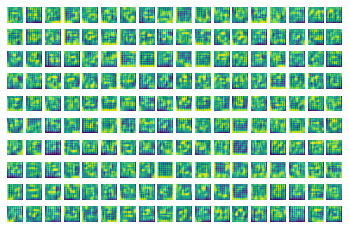

In [100]:
from tensorflow.keras.models import load_model
from matplotlib import pyplot as plt
from numpy import asarray

n_classes = len(artists) #18
samples = 180

# load generator
Generator = load_model('cGAN_generator.h5')

# generate images
latent_points, labels = generate_latent_points(samples, 100, n_classes)
    #for i in range(10): print(latent_points[i].shape, labels.shape)
    #print(samples,"vectors length 100", latent_points.shape, " - ", samples, " vectors length 1", labels.shape)

# specify labels
labels = asarray([x for _ in range(10) for x in range(n_classes)])

# generate images
X = Generator.predict([latent_points, labels])
# scale from [-1,1] to [0,1]
X = (X + 1) / 2.0

# plot the result
plot_matrix(X, int(samples/n_classes), n_classes)


#### Extract an image for visualization purpose

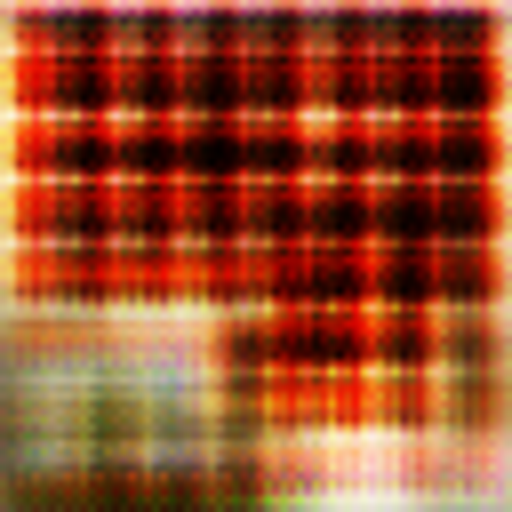

In [101]:
img = X[randint(0,180)]
img = (img * 255).astype(np.uint8)
img = Image.fromarray(img).resize((512,512))
img

https://machinelearningmastery.com/how-to-develop-a-conditional-generative-adversarial-network-from-scratch/

# IDEAS

* far generare immagini con     crea("landscape","abstract")
* metterlo su un sito